# HMC

In [1]:
import numpy as np
import pymc3 as pm

import aesara
import aesara.tensor as aet
from aesara.tensor.random.utils import RandomStream
from aeppl.transforms import TransformValuesOpt, LogTransform

from aeppl import joint_logprob

import aehmc.hmc as hmc
from aehmc.utils import RaveledParamsMap

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
NUM_INTEGRATION_STEPS = 1024
STEP_SIZE = 5e-5
PATH_LENGTH = STEP_SIZE * NUM_INTEGRATION_STEPS

NUM_SAMPLES = 1_000
BURNIN = 100

## The model: a simple linear regression

We consider a simple one-dimensional regression problem. To make it a little challenging, we create a dataset with 10,000 points:

In [4]:
X_val = np.random.normal(0, 1, size=(10_000,))
y_val = 3 * X_val + np.random.normal(0,1)

### PyMC3 implementation

In [5]:
with pm.Model() as pymc3_model:
    weights = pm.Normal("weights", mu=0, sigma=1)
    noise = pm.Gamma("noise", alpha=2, beta=1)
    y_observed = pm.Normal(
        "y_observed",
        mu=X @ weights,
        sigma=noise,
        observed=y,
    )

NameError: name 'X' is not defined

### Aeppl implementation

We can implement the posterior log-probability density function of this model directly using `aesara` and `aeppl`:

In [9]:
X_at = aet.as_tensor(X_val)

N_rv = aet.random.gamma(2.0, 1.0, name="N")
W_rv = aet.random.normal(0, 1.0, name="W")
Y_rv = aet.random.normal(X_at.dot(W_rv), N_rv, name="Y")


# `aehmc` kernels take a vector as an input. We use a `RaveledParamsMap` to unravel this vector
# and retrieve ta values for `W_rv` and `Y_rv`.
rp_map = RaveledParamsMap((W_rv, N_rv))


def aeppl_logprob(q):
    uraveled_params = rp_map.unravel_params(q)
    N_vv = uraveled_params[N_rv]
    W_vv = uraveled_params[W_rv]
    
    # The gamma distribution's support is the positive real numbers; algorithms like HMC however prefer to 
    # with parameters on the real line. We thus apply a log transform to `N_vv`. PyMC3 applies this 
    # transform automatically.
    transforms_op = TransformValuesOpt({N_vv: LogTransform()})

    logprob = joint_logprob(Y_rv, {Y_rv: aet.as_tensor(y_val), N_rv: N_vv, W_rv: W_vv}, extra_rewrites=transforms_op)
    return logprob

In [10]:
q = aet.vector('q')

logprob_fn = aesara.function((q,), aeppl_logprob(q))
logprob_fn([3., np.log(10.)])

array(-32227.18839188)

We can check that the loglikelihood returns the same values as the logpdf produced by PyMC3:

In [11]:
pymc3_model.fastlogp({'weights':3, 'noise_log__': np.log(10)})

array(-10.81376835)

## Sampling with aehmc

### Build the HMC kernel

The `hmc.kernel` function returns, given the parameters of the HMC algorithm (a random seed, the potential, the step size, inverse mass matrix and number of integration steps) returns a "kernel" which given a chain state returns a graph that computes the next chain state:

In [12]:
srng = RandomStream(seed=1)
inverse_mass_matrix = aet.as_tensor(np.array([1., 1.]))
kernel = hmc.kernel(srng, aeppl_logprob, STEP_SIZE, inverse_mass_matrix, NUM_INTEGRATION_STEPS)

Let us compile this graph into a function:

In [13]:
q = aet.vector("q")
potential_energy = -aeppl_logprob(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

next_step = kernel(q, potential_energy, potential_energy_grad)
kernel_fn = aesara.function((q,), next_step)

Let's execute it for one position:

In [14]:
kernel_fn(np.array([3., np.log(.21)]))

[array([ 3.00280254, -1.64604608]),
 array(-4196.38241395),
 array([1703.66049661, 3868.43841482])]

### Build the trajectory

We can also build a graph that computes the entire trajectory given the initial position and a number of samples, using aesara `scan` construct:

In [15]:
def build_trajectory_generator(srng, kernel_generator, logprob_fn, num_samples):
    """Builds a function which, given an initial position, returns the full trajectory."""
    q = aet.vector("q")
    potential_energy = -logprob_fn(q)
    potential_energy_grad = aesara.grad(potential_energy, wrt=q)

    step_size = aet.scalar("step_size")
    inverse_mass_matrix = aet.vector("inverse_mass_matrix")
    num_integration_steps = aet.scalar("num_integration_steps", dtype="int32")

    kernel = kernel_generator(
        srng, logprob_fn, step_size, inverse_mass_matrix, num_integration_steps
    )

    trajectory, updates = aesara.scan(
        fn=kernel,
        outputs_info=[
            {"initial": q},
            {"initial": potential_energy},
            {"initial": potential_energy_grad},
        ],
        n_steps=num_samples,
    )
    trajectory_generator = aesara.function(
        (q, step_size, inverse_mass_matrix, num_integration_steps),
        trajectory,
        updates=updates,
        mode='FAST_RUN'
    )

    return trajectory_generator

We can now compile the function that generates the chain and execute it:

In [16]:
%%time
trajectory_generator = build_trajectory_generator(
    srng, hmc.kernel, aeppl_logprob, num_samples=NUM_SAMPLES
)

initial_position = np.array([3., np.log(1.5)])
inverse_mass_matrix = np.array([1., 1.])
position, *_ = trajectory_generator(initial_position, STEP_SIZE, inverse_mass_matrix, NUM_INTEGRATION_STEPS)

CPU times: user 47.3 s, sys: 39.5 ms, total: 47.4 s
Wall time: 47.8 s


Let us quickly check that the chain sampled correctly:

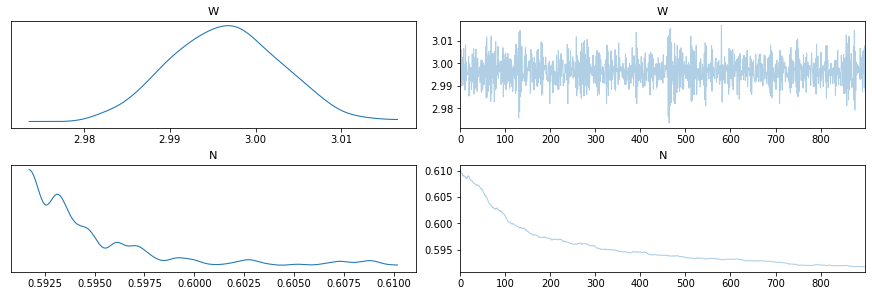

In [17]:
import arviz as az

aehmc_trace = az.from_dict(posterior={"W": position[BURNIN:, 0], "N": np.exp(position[BURNIN:, 1])})
az.plot_trace(aehmc_trace);

## Sampling with PyMC3

We are now ready to compare the performance of `aehmc`'s HMC kernel to that of PyMC3.

In [ ]:
import time 

with pymc3_model:
    step = pm.step_methods.hmc.hmc.HamiltonianMC(
        [weights, noise],
        path_length=PATH_LENGTH,
        step_scale=STEP_SIZE,
        adapt_step_size=False,
    )
    
    # Set initial values
    weights.tag.test_value = initial_position[0]
    noise.tag.test_value = initial_position[1]
    
with pymc3_model:
    start = time.perf_counter()
    posterior = pm.sample(
        tune=0,
        draws=NUM_SAMPLES,
        step=[step],
        chains=1,
        cores=1,
        return_inferencedata=False,
        compute_convergence_checks=False
    )
    end = time.perf_counter()
    print(end - start)

In [ ]:
posterior_trace = az.from_pymc3(posterior[BURNIN:], model=pymc3_model)
az.plot_trace(posterior_trace);